# Exercise 1: Optimize lepton selection

* First, print the distributions of the relevant variables for *all* the Monte Carlo samples (i.e. all the *channels* of the $Z$-boson decay to be studied). Which variables are these? Give sensible ranges to include all the events in the samples (both MC and OPAL data) 
* Do the same for **one** of the OPAL data samples (your lab assistant will decide which one you choose).
* Describe the results.
* Optimize the object selection by applying cuts. Make a strategy on how to proceed to find the optimal selection. which information do you need?
* Determine the efficiency and the amount of background for each $Z$ decay channel. Use the simulated events $e^+e^-$, $\mu^+\mu^-$, $\tau^+\tau^-$ and hadrons ($qq$). Represent the result in a matrix form and think carefully about how you have to correct the measured rates. Don't forget to calculate the errors!
* How do we estimate the statistical fluctuations per bin?

#### Import libraries and functions

In [1]:
import uproot
import awkward as ak
import mplhep
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


In [2]:
def get_efficiency_matrix(data,cuts,relevant_vars):
    efficiency_matrix = np.zeros((4,4))
    error_matrix = np.zeros((4,4))

    el={'ee': 0,'mm':1,'qq':2,'tt':3}
    
    ### Calculate the efficiency matrix elements and errors
    # store the errors in an extra matrix
     
    # How are the efficiency matrix and the corresponding error calculated?
    # For each selection (z0 -> {ee,mm,qq,tt}) there are known cuts (from looking at te MC data)
    # the calculated efficiency of the distinction between two channels from above (labeled with i and j) will be stored in the (i,j) component of the efficiency matrix eps_(i,j)
    # In relevant_vars the variables, which are needed for a proper distinction (selected by looking at MC data) are stored for each pair of possible channels
    # The cuts (stored in cuts) are applied to the relevant variables (by masking the awkward arrays)
    # The (estimator of) efficiency is than calculated by
    #                                                        eps = passed (=: k) / total (=:N)
    # How to calculate the errors ?
    # The (estimated) efficiency is the probability of succes with a certain selection. 
    # For succes failure experiments it is known, that the probability to get k times succes out of N trials is
    # 
    #               P(k;N,eps) = binom(N,k) * eps^k *(1-eps)^(N-k)    
    #
    # k is a possible value of a probability variable X which counts the succes times X = sum_{i=1,...,N} Y (distribution of Y = Bernoulli)
    #
    # The maximum likelihood estimator (MLE) is eps = X / N = k / N
    # The variance is V(eps) = V(X/N) = 1/N^2 sum(V(X)) = 1/N^2 V(sum_{i=1,...,N} Y) = 1/ N V(Y) = 1/N eps(1-eps)
    # Summary: eps = k/N, sigma_eps^2 = 1/N eps(1-eps) -> sigma_eps = sqrt(1/N eps(1-eps))
    
    # However this methods results in absurd limiting cases: for eps = 0,1 the error is 0. This is unphysical
    # A correct treatment of the errors is supplied in https://arxiv.org/abs/physics/0701199. We use their results directly in the code below:
    
    for channel_i,cuts_i in cuts.items():
        for channel_j,rel_vars in relevant_vars[channel_i].items():
            passed = 0
            total = 0
            for var in rel_vars:
                mask0 = data[channel_j][var]>= cuts_i[var][0]
                mask1 = data[channel_j][var] < cuts_i[var][1]
                total +=len(mask0)
                passed += sum(mask0)+sum(mask1)-len(mask0)
            eps = (passed+1)/(total+2)
            efficiency_matrix[el[channel_i]][el[channel_j]]=eps
            error_matrix[el[channel_i]][el[channel_j]] = np.sqrt(eps * (passed+2)/(total+3) - eps**2)


    return efficiency_matrix,error_matrix

#### Load the relevant data

In [3]:
### Specify the folder path for MC samples
path_data = 'data/'

### Open the file introducing file path
mc_data_ee = uproot.open(path_data+'ee.root')
mc_data_mm = uproot.open(path_data+'mm.root')
mc_data_qq = uproot.open(path_data+'qq.root')
mc_data_tt = uproot.open(path_data+'tt.root')
ttree_name = 'myTTree'

### Print list of 'branches' of the TTree (i.e. list of variable names)
# print(mc_data_ee[ttree_name].keys())

### Load branches
branches_ee = mc_data_ee[ttree_name].arrays()
branches_mm = mc_data_mm[ttree_name].arrays()
branches_qq = mc_data_qq[ttree_name].arrays()
branches_tt = mc_data_tt[ttree_name].arrays()


### List of variables (of interest)
variables=['Pcharged', 'Ncharged', 'E_ecal', 'E_hcal']
channels=['ee','mm','qq','tt'] 

# print(channels)
# print(len(channels))

### For later purposes (to calculate efficiency matrix) we store the data from braches into a list
mc_data = {'ee' : {}, 'mm' : {}, 'qq' : {}, 'tt' : {}}
mc_data['ee'] = branches_ee
mc_data['mm'] = branches_mm
mc_data['qq'] = branches_qq
mc_data['tt'] = branches_tt




### Read in the variables for all MC data samples
Pchar=ak.Array([branches_ee[variables[0]],branches_mm[variables[0]],branches_qq[variables[0]],branches_tt[variables[0]]])
Nchar=ak.Array([branches_ee[variables[1]],branches_mm[variables[1]],branches_qq[variables[1]],branches_tt[variables[1]]])
E_ecal=ak.Array([branches_ee[variables[2]],branches_mm[variables[2]],branches_qq[variables[2]],branches_tt[variables[2]]])
E_hcal=ak.Array([branches_ee[variables[3]],branches_mm[variables[3]],branches_qq[variables[3]],branches_tt[variables[3]]])

#### Plot the MC data samples to nice looking histograms

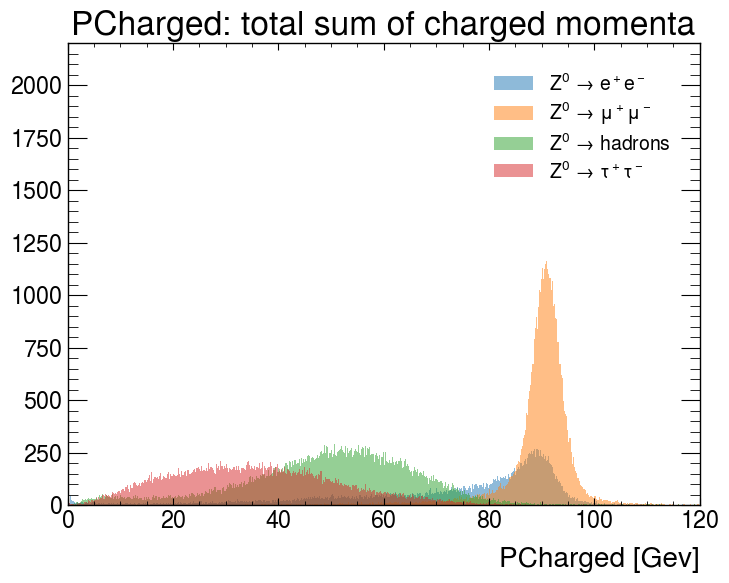

In [4]:
labels=[r'$Z^0$ $\to$ $e^+e^-$',r'$Z^0$ $\to$ $\mu^+\mu^-$',r'$Z^0$ $\to$ hadrons',r'$Z^0$ $\to$ $\tau^+\tau^-$']
plt.style.use(mplhep.style.ATLAS) # load ATLAS plot style
plt.title(r'PCharged: total sum of charged momenta')
for i in np.arange(4):
    plt.hist(ak.to_numpy(Pchar[i]),bins=np.arange(0,120,0.1),label=labels[i],alpha=0.5)
    
plt.xlim(0,120)
plt.ylim(0,2200)
plt.xlabel(r'PCharged [Gev]')
plt.legend()
plt.savefig('pchar_hist.png')
plt.show()

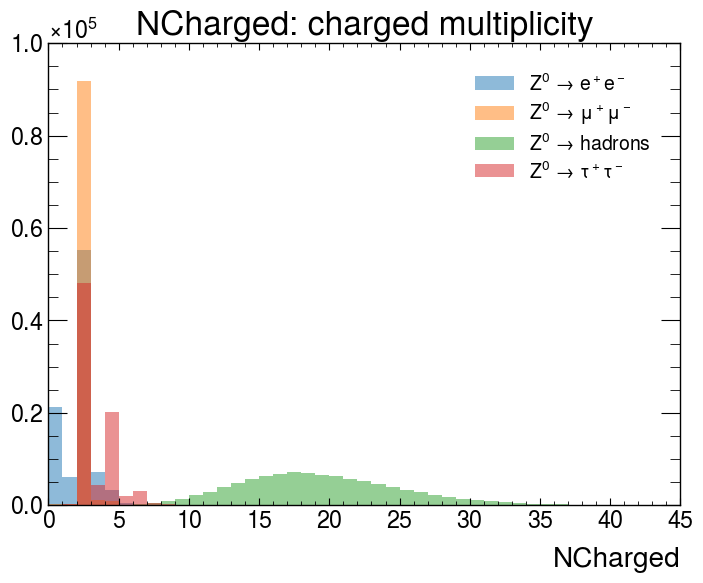

In [5]:
plt.title(r'NCharged: charged multiplicity')
for i in np.arange(4):
    plt.hist(ak.to_numpy(Nchar[i]),bins=np.arange(0,60,1),label=labels[i],alpha=0.5)

plt.xlim(0,45)
plt.ylim(0,100000)
plt.xlabel(r'NCharged')
plt.legend()
plt.savefig('nchar_hist.png')
plt.show()

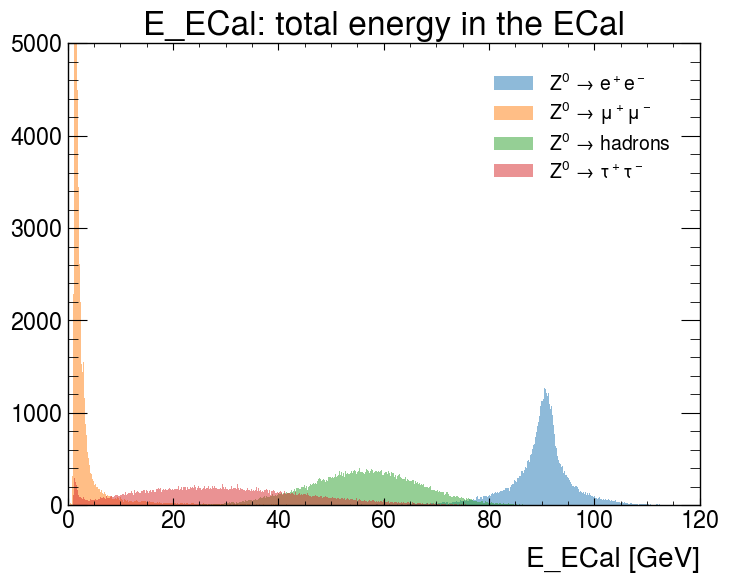

In [6]:
plt.title(r'E_ECal: total energy in the ECal')
for i in np.arange(4):
    plt.hist(ak.to_numpy(E_ecal[i]),bins=np.arange(0,120,0.1),label=labels[i],alpha=0.5)

plt.xlim(0,120)
plt.ylim(0,5000)
plt.xlabel(r'E_ECal [GeV]')
plt.legend()
plt.savefig('e_ecal_hist.png')
plt.show()

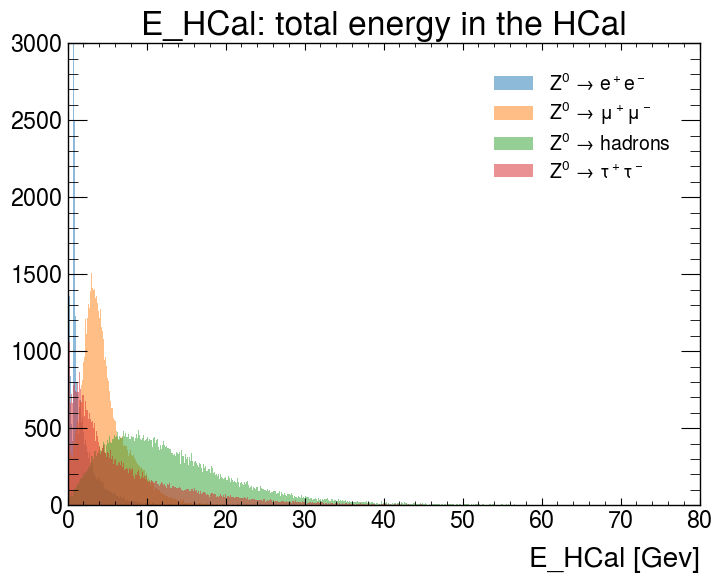

In [7]:
plt.title(r'E_HCal: total energy in the HCal')
for i in np.arange(4):
    plt.hist(ak.to_numpy(E_hcal[i]),bins=np.arange(0,80,0.08),label=labels[i],alpha=0.5)

plt.xlim(0,80)
plt.ylim(0,3000)
plt.xlabel(r'E_HCal [Gev]')
plt.legend()
plt.savefig('e_hcal_hist.png')
plt.show()

#### Cut strategy
We apply cuts to every variable of each channel (stored in cuts). To distinguish different decay channels of the Z0 boson, different variables are relevant for different distinctions (stored relevant_vars). With this information, the efficiency of event selection can be calculated. The results will be represented on a 4x4 "efficiency matrx".
For explanation how the efficiency and the corresponding errors are calculated, see $\texttt{functions.py}$.

In [8]:
cuts = {'ee' : {'Pcharged':(0,200), 'Ncharged':(0,7),'E_ecal':(65,200),'E_hcal':(0,5)}, 
         'mm' : {'Pcharged':(75,200), 'Ncharged':(1,7),'E_ecal':(0,27),'E_hcal':(0,40)}, 
         'qq' : {'Pcharged':(0,200), 'Ncharged':(7,200),'E_ecal':(27,90),'E_hcal':(0,100)},
         'tt' : {'Pcharged':(0,75), 'Ncharged':(2,7),'E_ecal':(0,65),'E_hcal':(0,50)}}

In [9]:
relevant_vars={'ee': {'ee':['Pcharged','Ncharged','E_ecal','E_hcal'],'mm':['E_ecal'],'qq': ['Ncharged'],'tt':['E_ecal']},
               'mm': {'ee':['E_ecal'],'mm':['Pcharged','Ncharged','E_ecal','E_hcal'],'qq':['Ncharged'],'tt':['Pcharged']},
               'qq': {'ee':['Ncharged'],'mm':['Ncharged'],'qq':['Pcharged','Ncharged','E_ecal','E_hcal'],'tt':['Ncharged']},
               'tt': {'ee':['E_ecal'],'mm':['Pcharged'],'qq':['Ncharged'],'tt':['Pcharged','Ncharged','E_ecal','E_hcal']}}


In [10]:
efficiency_matrix,error_matrix = get_efficiency_matrix(mc_data,cuts,relevant_vars)
print(f"efficiency matrx: \n", efficiency_matrix, "\n")
print(f"error matrix: \n", error_matrix)

efficiency matrx: 
 [[9.87900109e-01 3.17853851e-05 5.28585198e-03 2.27731771e-02]
 [1.06605262e-05 9.71628444e-01 5.28585198e-03 1.45046455e-02]
 [2.77173681e-04 1.05951284e-05 9.96111644e-01 1.23333670e-02]
 [9.92494990e-03 9.11392942e-02 5.28585198e-03 9.85561356e-01]] 

error matrix: 
 [[1.78488180e-04 1.83509118e-05 2.30963355e-04 5.30029822e-04]
 [1.06604126e-05 2.70220117e-04 2.30963355e-04 4.24787428e-04]
 [5.43504076e-05 1.05950161e-05 9.91170639e-05 3.92136098e-04]
 [3.23657165e-04 9.36811697e-04 2.30963355e-04 2.11920037e-04]]


### Matrix Inversion
To determine the uncertainties of the matrix elements after the inversion we use Monte Carlo toy experiments. In this context, what are the advantages and disadvantages of this method when compared to analytical expressions? Discuss it briefly.

**References**:
* Propagation of Errors for Matrix Inversion: https://arxiv.org/abs/hep-ex/9909031v1

In [11]:
### Number of toy experiments to be done
ntoy = 100000

### Create numpy matrix of list to append elements of inverted toy matrices
inverse_toys = np.empty((4,4))

# Create toy efficiency matrix out of gaussian-distributed random values
for i in range(0,ntoy,1):
    toy_matrix = np.zeros((4,4))
    #np.random.seed(2)
    toy_matrix = np.random.normal(efficiency_matrix,error_matrix,size=(4,4))
    
    ### Invert toy matrix
    inverse_toy = np.linalg.inv(toy_matrix)
    
    #print(inverse_toys.item(0,0),inverse_toy.item(0,0))
    # Append values
    
    inverse_toys = np.dstack((inverse_toys,inverse_toy))


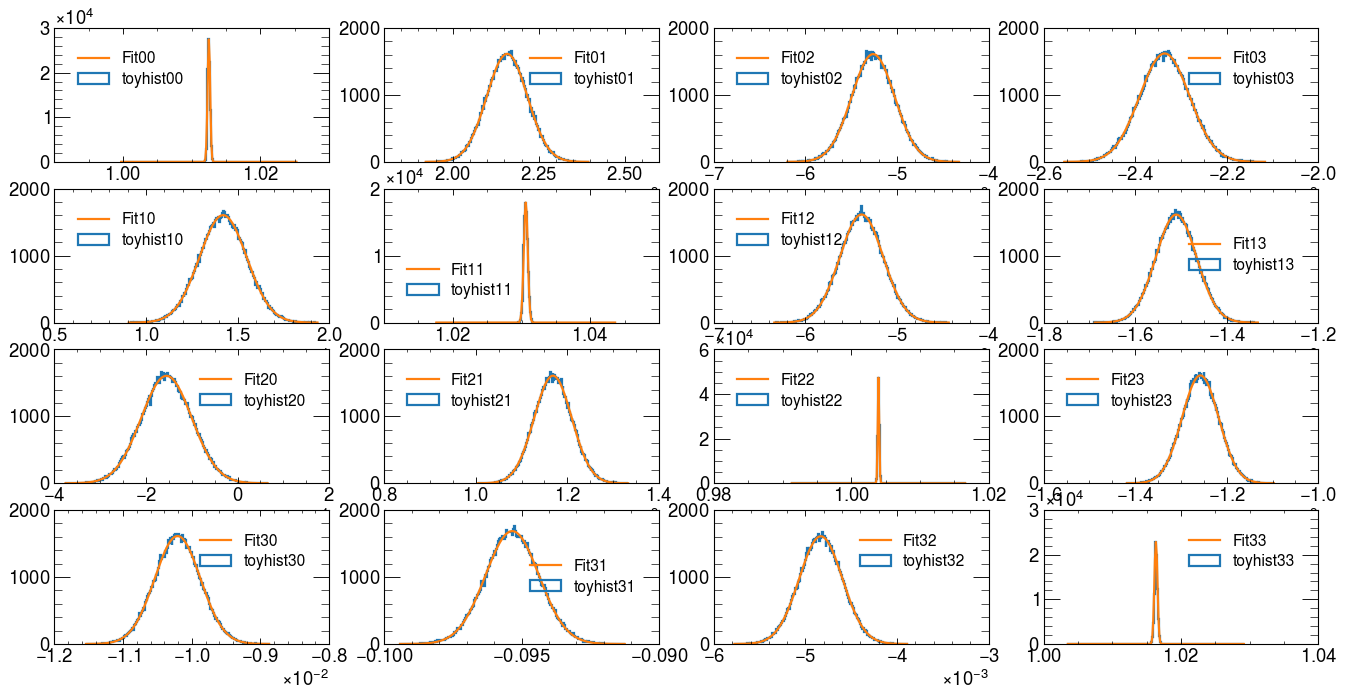

Inverse efficiency matrix:
[[ 1.01248424e+00  2.15823058e-03 -5.26021960e-03 -2.33612154e-02]
 [ 1.42128861e-04  1.03061678e+00 -5.38956032e-03 -1.51035715e-02]
 [-1.55335757e-04  1.16881348e-03  1.00396490e+00 -1.25772822e-02]
 [-1.02083830e-02 -9.53337751e-02 -4.83318636e-03  1.01634958e+00]]
Erros for the inverse matrix:
[[1.87090019e-04 5.92090929e-05 2.34426638e-04 5.45635004e-04]
 [1.29495955e-05 2.92200811e-04 2.37466970e-04 4.45507210e-04]
 [5.54052958e-05 4.11047031e-05 1.07439657e-04 4.01694656e-04]
 [3.33005616e-04 9.76201494e-04 2.36198442e-04 2.25645076e-04]]


In [12]:
# Define gaussian function to fit to the toy distributions:
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

inverse_errors = np.zeros((4,4))
inverse_means = np.zeros((4,4))


fig = plt.figure(figsize=(20, 10),dpi=80)
plt.style.use(mplhep.style.ATLAS) # load ATLAS plot style
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)
ax00 = plt.subplot(4,4,1)
ax01 = plt.subplot(4,4,2)
ax02 = plt.subplot(4,4,3)
ax03 = plt.subplot(4,4,4)

ax10 = plt.subplot(4,4,5)
ax11 = plt.subplot(4,4,6)
ax12 = plt.subplot(4,4,7)
ax13 = plt.subplot(4,4,8)

ax20 = plt.subplot(4,4,9)
ax21 = plt.subplot(4,4,10)
ax22 = plt.subplot(4,4,11)
ax23 = plt.subplot(4,4,12)

ax30 = plt.subplot(4,4,13)
ax31 = plt.subplot(4,4,14)
ax32 = plt.subplot(4,4,15)
ax33 = plt.subplot(4,4,16)

axes = [[ax00,ax01,ax02,ax03],
        [ax10,ax11,ax12,ax13],
        [ax20,ax21,ax22,ax23],
        [ax30,ax31,ax32,ax33]]


# Fill histograms for each inverted matrix coefficient:
for j in range(0,4,1):
    for k in range(0,4,1):
        
        ## Guess initial parameters for the fit, use them for proper ranges of the histograms below
        p0 = [ntoy/10.,np.mean(inverse_toys[j,k,:]),np.std(inverse_toys[j,k,:])]
        
        # Generate the histograms of the matrix elements of the toys
        hbins, hedges, _ = axes[j][k].hist(inverse_toys[j,k,:],bins=np.linspace(p0[1]-4*p0[2],p0[1]+4*p0[2],200),
                                           histtype='step', linewidth=2, label=f'toyhist{j}{k}')
        


        # Get the fitted curve
        h_mid = 0.5*(hedges[1:] + hedges[:-1]) #Calculate midpoints for the fit
        coeffs, _ = curve_fit(gauss, h_mid, hbins,p0, maxfev=1000)
        h_fit = gauss(h_mid, *coeffs)
        
        axes[j][k].plot(h_mid, h_fit,label=f'Fit{j}{k}')
        
        axes[j][k].legend()
        
        

        inverse_means[j,k] = coeffs[1]
        inverse_errors[j,k] = abs(coeffs[2])
        
plt.show()

inv_efficiency_matrix = np.linalg.inv(efficiency_matrix)
print(f"Inverse efficiency matrix:\n{inv_efficiency_matrix}")
print(f"Erros for the inverse matrix:\n{inverse_errors}")

In [13]:
np.save(path_data+'efficiency_matrix',efficiency_matrix)
np.save(path_data+'error_matrix',error_matrix)
np.save(path_data+'inv_efficiency_matrix',inv_efficiency_matrix)
np.save(path_data+'inv_error_matrix',inverse_errors)